# Prediction
This notebook contains prediction of womanswear's size

In [24]:
# import some libraries
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.model_selection import KFold

# Loading data

In [7]:
#load training and testing data

raw_train = pd.read_csv("uc_data_train.csv", encoding='UTF-8')
raw_train = raw_train.loc[:, ~raw_train.columns.str.contains('Unnamed')]
raw_test = pd.read_csv("uc_data_test.csv", encoding='UTF-8')
raw_test = raw_test.loc[:, ~raw_test.columns.str.contains('Unnamed')]
predicted_test = raw_test.copy()

train_label = raw_train.loc[:, ['size_womenswear']].values.ravel()
print('size of train label:', train_label.shape)

#apply label encoder
categorical = ['socioeconomic_desc', 'brand', 'socioeconomic_status', 'order_method']
raw_train[categorical] = raw_train[categorical].apply(LabelEncoder().fit_transform)
raw_test[categorical] = raw_test[categorical].apply(LabelEncoder().fit_transform)

#check the number of customer and features
print('size of predicted test:', predicted_test.shape)
print('size of raw train:',raw_train.shape)
print('size of raw test:',raw_test.shape)
print(raw_train.head())

size of train label: (80001,)
size of predicted test: (19999, 13)
size of raw train: (80001, 14)
size of raw test: (19999, 13)
   customer_id  size_womenswear  total_number_of_orders  return_rate  \
0            1               16                      28         0.12   
1            2               20                     118         0.61   
2            3                8                     125         0.04   
3            4               12                     109         0.42   
4            5               16                      37         0.26   

   first_order_channel  socioeconomic_status  size_corsetry_cup  \
0                    1                     2                  7   
1                    2                     7                  3   
2                    2                     5                  3   
3                    1                     5                  5   
4                    1                     8                  4   

   size_corsetry_briefs  size_footwar

# Feature extraction

Feature ranking:
1. feature 1 (0.740571)
2. feature 7 (0.209473)
3. feature 8 (0.010654)
4. feature 9 (0.006350)
5. feature 0 (0.005655)
6. feature 11 (0.005526)
7. feature 2 (0.005452)
8. feature 3 (0.004811)
9. feature 6 (0.003494)
10. feature 5 (0.002784)
11. feature 12 (0.002563)
12. feature 10 (0.001513)
13. feature 4 (0.000584)
14. feature 13 (0.000570)


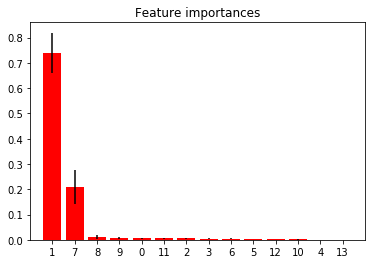

In [8]:
forest = RF(n_estimators = 50, max_depth=15, random_state=50, 
                         bootstrap=False)

forest.fit(raw_train, train_label)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(raw_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(raw_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(raw_train.shape[1]), indices)
plt.xlim([-1, raw_train.shape[1]])
plt.show()

#based on ranking, only take 9 features

In [14]:
#select some columns as features
features = ['total_number_of_orders', 'return_rate', 'socioeconomic_desc',
           'size_corsetry_cup', 'size_corsetry_briefs', 'size_footware', 'days_since_first_order', 
            'brand', 'age_in_years']

#training data
train_data = raw_train[features]
print(train_data.shape)
print(train_data.head())
#testing data
test_data = raw_test[features]
print(test_data.shape)

(80001, 9)
   total_number_of_orders  return_rate  socioeconomic_desc  size_corsetry_cup  \
0                      28         0.12                   2                  7   
1                     118         0.61                   0                  3   
2                     125         0.04                  11                  3   
3                     109         0.42                  11                  5   
4                      37         0.26                   4                  4   

   size_corsetry_briefs  size_footware  days_since_first_order  brand  \
0                    16              7                    4964      0   
1                    20              6                    5578      3   
2                    12              4                    4112      3   
3                    12              7                    4261      0   
4                    16              6                    2432      3   

   age_in_years  
0            47  
1            73  
2        

In [17]:
#scale all the features
train_data = StandardScaler().fit_transform(train_data)
test_data = StandardScaler().fit_transform(test_data)

In [19]:
#Cross validation

classes = ['8', '12', '16', '20', '24', '28', '32', '36']
class_weight = dict({8:50, 12:3.8, 16:2, 20:1.6, 24:3, 28:8, 32:26, 36:500})
model = RF(n_estimators = 50, max_depth=15, random_state=50, 
                         bootstrap=True, class_weight=class_weight)

#measure accuracy with k-fold
print("Micro averaged f1 on training data with Cross-validation:")
#split training data into 10 fold, and calculate the score by accuracy 
cv_results = model_selection.cross_val_score(model, train_data, train_label, 
                                            cv = KFold(n_splits=10), 
                                            scoring = 'f1_micro')

#print the result, its mean and standard deviation
msg = "%.3f (%.3f)" % (cv_results.mean(), cv_results.std())
print(msg)

Micro averaged f1 on training data with Cross-validation:
0.690 (0.004)


In [22]:
#fit data into a classifier

training = RF(n_estimators = 50, max_depth=15, random_state=50, 
                         bootstrap=False, class_weight=class_weight).fit(train_data, train_label)
train_pred = training.predict(train_data)
test_pred = training.predict(test_data)

#concat prediction into test dataframe
predicted_test['size_womenswear'] = test_pred
print(predicted_test.head())

#save into csv
predicted_test.to_csv('Prediction of size womenswear.csv', index=False, encoding='utf-8')

   customer_id  total_number_of_orders  return_rate  first_order_channel  \
0            7                      17         0.26                    2   
1            8                      30         0.52                    2   
2            9                       9         0.31                    2   
3           13                     109         0.08                    2   
4           24                     135         0.10                    2   

  socioeconomic_status  size_corsetry_cup  size_corsetry_briefs  \
0                    M                  4                    20   
1                    L                  4                    16   
2                    I                  9                    16   
3                    M                  3                    16   
4                    F                  3                    24   

   size_footware  days_since_first_order    brand  age_in_years  \
0              6                    1602  Brand 3            43   
1     

0.7683278959013011


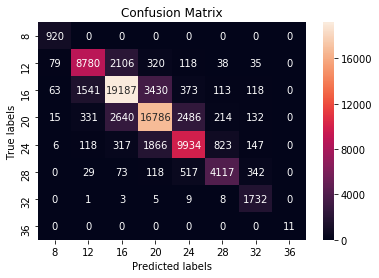

             precision    recall  f1-score   support

          8       0.85      1.00      0.92       920
         12       0.81      0.77      0.79     11476
         16       0.79      0.77      0.78     24825
         20       0.75      0.74      0.74     22604
         24       0.74      0.75      0.75     13211
         28       0.77      0.79      0.78      5196
         32       0.69      0.99      0.81      1758
         36       1.00      1.00      1.00        11

avg / total       0.77      0.77      0.77     80001



In [25]:
#create confusion matrix 
conf_matrix = confusion_matrix(train_label, train_pred)

#print f1 score
f1 = f1_score(train_label, train_pred, average='micro')
print(f1)

#create a visualisation on the confusion matrix
ax = plt.subplot()
sns.heatmap(conf_matrix, annot=True, ax=ax, fmt='d')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(classes)
ax.yaxis.set_ticklabels(classes)
plt.show()

#print a classification report
print(classification_report(train_label, train_pred))